# 0. Librerias

In [1]:
# Genérica
# -----------------------------------------------------------------------------
from time import time
import session_info


# Tratamientos datos
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np


# category encoders
# -----------------------------------------------------------------------------
from category_encoders import OrdinalEncoder


# scikit-learn
# -----------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# LightGBM
# -----------------------------------------------------------------------------
import lightgbm as lgb


# Gráficos
# -----------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt


session_info.show(html=False)

-----
category_encoders   2.6.1
lightgbm            3.3.5
matplotlib          3.7.2
numpy               1.23.5
pandas              1.5.3
seaborn             0.12.2
session_info        1.0.0
sklearn             1.3.0
-----
IPython             8.14.0
jupyter_client      8.3.0
jupyter_core        5.3.1
notebook            6.5.4
-----
Python 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
Linux-5.15.0-100-generic-x86_64-with-glibc2.31
-----
Session information updated at 2024-03-11 09:55


In [2]:
# Funciones
# -----------------------------------------------------------------------------
def optimize_df_dtypes(df):

    variables_categoricas = [
        'Epoca_Covid',
        'Anio',
        'Trimestre',
        'Mes',
        'Cliente',
        'Tipo_Cliente',
        'Distribuidor_MSM',
        'Codigo_Postal',
        'Area_Dist',
        'Zona',
        'ID_CCAA',
        'Comunidad_Autonoma',
        'ID_Provincia',
        'Provincia',
        'Gama',
        'Formato_1',
        'Formato_2'
        ]

    for i in df.columns:
        if i in variables_categoricas:
            df[i] = df[i].astype("category")
 
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns

    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df 

# 1. Cargar datos

In [3]:
# Ruta
# path = './data/tablon-sell-in-4.csv' # Fase IV
# path = './data/tablon-sell-in-5.csv' # Fase V: Más histórico
path = './data/tablon-sell-in-6.csv' # Fase V: Numérica a nivel Formato_2 / Gama
# path = './data/tablon-sell-in-7.csv' # Fase V: Numérica a nivel Gama

# Cargar datos
#df = pd.read_csv(path, sep=',')
df = pd.read_csv(path, sep=';')

# Optimizar tipo dato
df = optimize_df_dtypes(df)

# Dataset completo
df_complete = df.copy()

# Datos de validación final
filter_val = ((df.Fecha >= 202310) & (df.Fecha <= 202312)) 
df_val = df[filter_val].reset_index(drop=True)

# Efecto Covid-19
filter_covid = ((df.Fecha < 202003) | (df.Fecha > 202108) & (df.Fecha <= 202309))
df = df[filter_covid].reset_index(drop=True)

df.head()

/tmp/ipykernel_20816/3549211703.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=';')


,Fecha,Fecha_Date,Epoca_Covid,Anio,Trimestre,Mes,Cliente,Tipo_Cliente,Distribuidor_MSM,Codigo_Postal,...,Temperatura_Minima,Temperatura_Media,Temperatura_Maxima,Precipitacion,Sell_In_3,Sell_In_2,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,201610,2016-10-01,pre-covid,2016,T4,10,534564,DHC,0,30004,...,15.11,20.379999,25.66,27.65,0.32,0.32,0.32,0.32,2024-03-07T13:35:13.804Z,202403
1,201610,2016-10-01,pre-covid,2016,T4,10,534564,DHC,0,30004,...,15.11,20.379999,25.66,27.65,0.00,0.00,0.00,0.00,2024-03-07T13:35:13.804Z,202403
2,201610,2016-10-01,pre-covid,2016,T4,10,534564,DHC,0,30004,...,15.11,20.379999,25.66,27.65,3.00,3.00,3.00,3.00,2024-03-07T13:35:13.804Z,202403
3,201610,2016-10-01,pre-covid,2016,T4,10,534564,DHC,0,30004,...,15.11,20.379999,25.66,27.65,0.06,0.06,0.06,0.06,2024-03-07T13:35:13.804Z,202403
4,201610,2016-10-01,pre-covid,2016,T4,10,534564,DHC,0,30004,...,15.11,20.379999,25.66,27.65,0.16,0.16,0.16,0.16,2024-03-07T13:35:13.804Z,202403


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000258 entries, 0 to 2000257
Data columns (total 61 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   Fecha                       int32   
 1   Fecha_Date                  object  
 2   Epoca_Covid                 category
 3   Anio                        category
 4   Trimestre                   category
 5   Mes                         category
 6   Cliente                     category
 7   Tipo_Cliente                category
 8   Distribuidor_MSM            category
 9   Codigo_Postal               category
 10  Area_Dist                   category
 11  Zona                        category
 12  ID_Provincia                category
 13  Provincia                   category
 14  ID_CCAA                     category
 15  Comunidad_Autonoma          category
 16  Gama                        category
 17  Descripcion_Gama            object  
 18  Formato_1                   category
 19  

In [5]:
df['Fecha'].nunique()

66

In [6]:
sorted(df['Fecha'].unique())

[201610,
 201611,
 201612,
 201701,
 201702,
 201703,
 201704,
 201705,
 201706,
 201707,
 201708,
 201709,
 201710,
 201711,
 201712,
 201801,
 201802,
 201803,
 201804,
 201805,
 201806,
 201807,
 201808,
 201809,
 201810,
 201811,
 201812,
 201901,
 201902,
 201903,
 201904,
 201905,
 201906,
 201907,
 201908,
 201909,
 201910,
 201911,
 201912,
 202001,
 202002,
 202109,
 202110,
 202111,
 202112,
 202201,
 202202,
 202203,
 202204,
 202205,
 202206,
 202207,
 202208,
 202209,
 202210,
 202211,
 202212,
 202301,
 202302,
 202303,
 202304,
 202305,
 202306,
 202307,
 202308,
 202309]

In [7]:
df['Fecha'].value_counts().sort_index()

201610    24484
201611    24484
201612    24484
201701    26270
201702    26270
          ...  
202305    34892
202306    34892
202307    34892
202308    34892
202309    34892
Name: Fecha, Length: 66, dtype: int64

In [8]:
df['Formato_1'].value_counts()

No Retornable    1074486
Retornable        489463
Barril            436309
Name: Formato_1, dtype: int64

In [9]:
# Eliminar columnas genéricas para todos los experimentos
df = df.drop(columns=[
    'Fecha',
    'Fecha_Date',
    'Anio',
    'Cliente',
    'Codigo_Postal',
    'Provincia',
    'Comunidad_Autonoma',
    'Descripcion_Gama',
    'Frontur',
    'Temperatura_Minima',
    'Temperatura_Maxima',
    'Movimientos_Entrada',
    'Movimientos_Salida',
    'Volumen_Entregado_Perfecto',
    'Numerica',
    'Sell_In_3',
    'Sell_In_2',
    # Poco feature importance
    'Numerica',
    'Num_Festivos_AI',
    'Distribuidor_MSM',
    'Impactos_OOH',
    'Impresiones_Digi',
    'Impresiones_Pint',
    'Trimestre',
    'Num_Festivos',
    'ID_CCAA',
    'Nivel_Servicio',
    'Zona',
    'Distancia_CdP',
    'Movimientos_Neto',
    'IPI',
    'Impresiones_Meta',
    # Campo de fecha
    'STRATIO_CREATED_DATE',
    'exec_month'
])

# Eliminar registros con NaN
df = df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000258 entries, 0 to 2000257
Data columns (total 28 columns):
 #   Column               Dtype   
---  ------               -----   
 0   Epoca_Covid          category
 1   Mes                  category
 2   Tipo_Cliente         category
 3   Area_Dist            category
 4   ID_Provincia         category
 5   Gama                 category
 6   Formato_1            category
 7   Formato_2            category
 8   Num_PdV_CI           float32 
 9   Num_PdV_RU           float32 
 10  Num_PdV_TU           float32 
 11  Impactos_TV          float64 
 12  Sell_In_PP           float64 
 13  Marketing_Nacional   float64 
 14  Trade_Marketing      float64 
 15  Marketing_PLV        float64 
 16  Dispersion_PdV       float32 
 17  Volumen_Solicitado   float64 
 18  Tarifa_Eur_Hl        float64 
 19  Margen_Distribuidor  float64 
 20  Egatur               float32 
 21  Familitur            float32 
 22  IPC                  float32 
 23  IPRI   

In [11]:
# Variable dependiente
target = 'Sell_In'

# Variables independientes
features = list(df.columns)
features.remove(target)

# Variables categóricas
categorical_features = [col for col in df.columns if df[col].dtype == 'category']

# Mostrar
print(f'Variable dependiente: {target}')
print(30*'-')
print(f'Variables independientes: {features}')
print(30*'-')
print(f'Variables categóricas: {categorical_features}')

Variable dependiente: Sell_In
------------------------------
Variables independientes: ['Epoca_Covid', 'Mes', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Sell_In_1']
------------------------------
Variables categóricas: ['Epoca_Covid', 'Mes', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2']


# 2. MLflow

In [12]:
# Importar MLflow
import mlflow
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema, ColSpec

In [13]:
# Ver ruta actual desde donde se va a levantar el MLflow server
!pwd

/home/gmachin/git/personal/project-sell-in-forecast


In [14]:
# Iniciar un servidor de MLflow con alguno de los dos comandos siguientes en una terminal
# $ mlflow server --host 127.0.0.1 --port 5000
# $ mlflow ui

In [15]:
# Apuntar el notebook al servidor MLflow levantado en la celda anterior
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [ ]:
# Crear un experimento
# --------------------------------------------------

# Nombre
experiment_name = "MSM_Sell_In_Modelos_Formato"

# Descripción
experiment_description = (
    "Proyecto de comparación de modelos de Sell In en función del Formato 1."
)

# Etiquetas del experimento
experiment_tags = {
    "project_name": "Modelos-Sell-In",
    "problem_type": "Regresión",
    "client": "MSM",
    "mlflow.note.content": experiment_description,
}

# Crear el experimento
produce_sell_in_experiment = mlflow.create_experiment(
    name=experiment_name,
    tags=experiment_tags
)

# Activar el experimento
mlflow.set_experiment(experiment_name)

# 3. Modelos

## 3.1. LightGBM - Modelo Global

In [16]:
# Medir tiempo
tiempo_inicial = time()


# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato'
run_name = 'Modelo_LightGBM_Experiment_Global_df06'
model_name = 'lightgbm-model-global-df06'


# Seed
# ------------------------------------------------------------------------------------
seed = 123


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset
df_exp = df.copy()

# Filtrar por el Formato_1: Global
# ...
# ...

# Variable dependiente
target = 'Sell_In'

# Variables independientes
features = list(df_exp.columns)
features.remove(target)

# Variables categóricas
categorical_features = [col for col in df_exp.columns if df_exp[col].dtype == 'category']

# Dataset de test y entrenamiento
train, test = train_test_split(df_exp, train_size=0.95, test_size=0.05, random_state=seed)



# MLflow
# ------------------------------------------------------------------------------------
# Activar el experimento
mlflow.set_experiment(experiment_name)

# Lanzar ejecución de MLflow
with mlflow.start_run(run_name=run_name) as run:
    
    # UUID del experimento
    experiment_id = run.info.experiment_id
    
    # UUID de la ejecución
    run_id = run.info.run_uuid
    
    # Instanciar OrdinalEncoder
    encoder = OrdinalEncoder(
        cols=categorical_features,
        handle_unknown="ignore",
        return_df=True
    )

    
    # Parámetros
    params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "n_estimators": 1000,
        "max_depth": 10,
        "num_leaves": 350,
        "min_child_samples": 20,
        "bagging_fraction": 1.0,
        "bagging_freq": 0,
        "feature_fraction": 0.8,
        "reg_sqrt": True,
        "feature_pre_filter": False,
        "random_state": seed,
        "n_jobs": -1
    }
    

    # Instanciar LGBMRegressor
    mlgb = lgb.LGBMRegressor(**params)

    
    # Pipeline: Encoder + Regresor
    model_pipeline = Pipeline([
        ("encoder", encoder),
        ("mlgb", mlgb)
    ])
    
    
    # Entrenar modelo
    model = model_pipeline.fit(train[features], train[target])
    
    
    # Cálculo de métricas
    train_y_real = train[target]
    train_y_pred = model.predict(train[features])

    test_y_real = test[target]
    test_y_pred = model.predict(test[features])

    metric_r2_train = round(r2_score(train_y_real, train_y_pred), 3)
    metric_r2_test = round(r2_score(test_y_real, test_y_pred), 3)

    metric_r2_adj_train = round(1-(1-metric_r2_train)*(len(test)-1)/(len(test)-len(features)-1), 3)
    metric_r2_adj_test = round(1-(1-metric_r2_test)*(len(test)-1)/(len(test)-len(features)-1), 3)

    metric_train_mae = round(mean_absolute_error(train_y_real, train_y_pred), 3)
    metric_test_mae = round(mean_absolute_error(test_y_real, test_y_pred), 3)

    metric_train_rmse = round(mean_squared_error(train_y_real, train_y_pred, squared=False), 3)
    metric_test_rmse = round(mean_squared_error(test_y_real, test_y_pred, squared=False), 3)

    metric_train_score = round(1.00 - (metric_train_mae / train_y_real.mean()), 3)
    metric_test_score = round(1.00 - (metric_test_mae / test_y_real.mean()), 3)
    
    
    # Genere un diccionario con las métricas
    metrics = {
        "r2_train": metric_r2_train,
        "r2_test": metric_r2_test,
        "r2_adj_train": metric_r2_adj_train,
        "r2_adj_test": metric_r2_adj_test,
        "mae_train": metric_train_mae,
        "mae_test": metric_test_mae,
        "rmse_train": metric_train_rmse,
        "rmse_test": metric_test_rmse,
        "score_train": metric_train_score,
        "score_test": metric_test_score
    }
    
    
    # Loggar parámetros
    mlflow.log_params(params)
    
    # Logar métricas
    mlflow.log_metrics(metrics)
    
    # Schema input/output del modelo
    input_schema = Schema([
        ColSpec("string", "Epoca_Covid"),
        ColSpec("string", "Mes"),
        ColSpec("string", "Tipo_Cliente"),
        ColSpec("string", "Area_Dist"),
        ColSpec("string", "ID_Provincia"),
        ColSpec("string", "Gama"),
        ColSpec("string", "Formato_1"),
        ColSpec("string", "Formato_2"),
        ColSpec("double", "Num_PdV_CI"),
        ColSpec("double", "Num_PdV_RU"),
        ColSpec("double", "Num_PdV_TU"),
        ColSpec("double", "Impactos_TV"),
        ColSpec("double", "Sell_In_PP"),
        ColSpec("double", "Marketing_Nacional"),
        ColSpec("double", "Trade_Marketing"),
        ColSpec("double", "Marketing_PLV"),
        ColSpec("double", "Dispersion_PdV"),
        ColSpec("double", "Volumen_Solicitado"),
        ColSpec("double", "Tarifa_Eur_Hl"),
        ColSpec("double", "Margen_Distribuidor"),
        ColSpec("double", "Egatur"),
        ColSpec("double", "Familitur"),
        ColSpec("double", "IPC"),
        ColSpec("double", "IPRI"),
        ColSpec("double", "Temperatura_Media"),
        ColSpec("double", "Precipitacion"),
        ColSpec("double", "Sell_In_1")
    ])
    
    output_schema = Schema([ColSpec("double", "prediction")])
    
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    # Log modelo entrenado
    mlflow.sklearn.log_model(model, model_name, signature=signature)

    
    
    
# Medir tiempo
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial

print('')
print(f"El tiempo de ejecución es de {tiempo_ejecucion/60} minutos")


# Info de la ejecución
print("")
print(f"Modelo loggado en el experimento: {experiment_id} --> {experiment_name}")
print(f"Modelo loggado en la ejecución: {run_id} --> {run_name}")
print(f"Nombre del modelo: {model_name}")
print(f"Modelo URI: 'runs:/{run_id}/{model_name}'")

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0

El tiempo de ejecución es de 2.492033135890961 minutos

Modelo loggado en el experimento: 766905929124975051 --> MSM_Sell_In_Modelos_Formato
Modelo loggado en la ejecución: 6e5fd9f9a68a4594b0a751656924c7af --> Modelo_LightGBM_Experiment_Global_df06
Nombre del modelo: lightgbm-model-global-df06
Modelo URI: 'runs:/6e5fd9f9a68a4594b0a751656924c7af/lightgbm-model-global-df06'


In [17]:
logged_model_lgb_global = f'runs:/{run_id}/{model_name}'
logged_model_lgb_global

'runs:/6e5fd9f9a68a4594b0a751656924c7af/lightgbm-model-global-df06'

### 3.1.1. Predicciones último mes

In [18]:
# Dataset para comprobar predicciones
df_val.head()

,Fecha,Fecha_Date,Epoca_Covid,Anio,Trimestre,Mes,Cliente,Tipo_Cliente,Distribuidor_MSM,Codigo_Postal,...,Temperatura_Minima,Temperatura_Media,Temperatura_Maxima,Precipitacion,Sell_In_3,Sell_In_2,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.59,0.49,0.34,0.66,2024-03-07T13:35:13.804Z,202403
1,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.55,0.48,0.32,0.48,2024-03-07T13:35:13.804Z,202403
2,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,8.50,10.50,6.00,6.00,2024-03-07T13:35:13.804Z,202403
3,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.12,0.18,0.12,0.18,2024-03-07T13:35:13.804Z,202403
4,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.00,0.08,0.00,0.00,2024-03-07T13:35:13.804Z,202403


In [19]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104676 entries, 0 to 104675
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Fecha                       104676 non-null  int32   
 1   Fecha_Date                  104676 non-null  object  
 2   Epoca_Covid                 104676 non-null  category
 3   Anio                        104676 non-null  category
 4   Trimestre                   104676 non-null  category
 5   Mes                         104676 non-null  category
 6   Cliente                     104676 non-null  category
 7   Tipo_Cliente                104676 non-null  category
 8   Distribuidor_MSM            104676 non-null  category
 9   Codigo_Postal               104676 non-null  category
 10  Area_Dist                   104676 non-null  category
 11  Zona                        104676 non-null  category
 12  ID_Provincia                104676 non-null  category
 13 

In [20]:
# Castear las columnas de tipo category a object
categorical_columns = df_val.select_dtypes(include=['category']).columns
df_val[categorical_columns] = df_val[categorical_columns].astype('object')

In [21]:
# Lista de variables dependientes
print(features)

['Epoca_Covid', 'Mes', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Sell_In_1']


In [22]:
# Cargar modelo como PyFuncModel.
# logged_model_lgb_global = 'runs:/35f3e23b74f14166a98322282a483129/lightgbm-model-global'
print(logged_model_lgb_global)
loaded_model_lgb = mlflow.pyfunc.load_model(logged_model_lgb_global)

# Prediccion
predictions = pd.Series(loaded_model_lgb.predict(df_val[features]), name='Sell_In_Pred')

runs:/6e5fd9f9a68a4594b0a751656924c7af/lightgbm-model-global-df06


In [23]:
# Columnas del análisis
df_analysis = df_val[['Area_Dist', 'Formato_1', 'Formato_2', 'Sell_In']]

# Concatenar dataset anterior con las predicciones
df_analysis = pd.concat([df_analysis, predictions], axis=1)

df_analysis.head()

,Area_Dist,Formato_1,Formato_2,Sell_In,Sell_In_Pred
0,ZZ,No Retornable,Tercio SR,0.66,0.097741
1,ZZ,No Retornable,Tercio SR,0.48,0.000004
2,ZZ,Barril,Barril,6.00,1.569077
3,ZZ,No Retornable,Cuarto SR,0.18,0.012895
4,ZZ,No Retornable,Lata,0.00,-0.000042


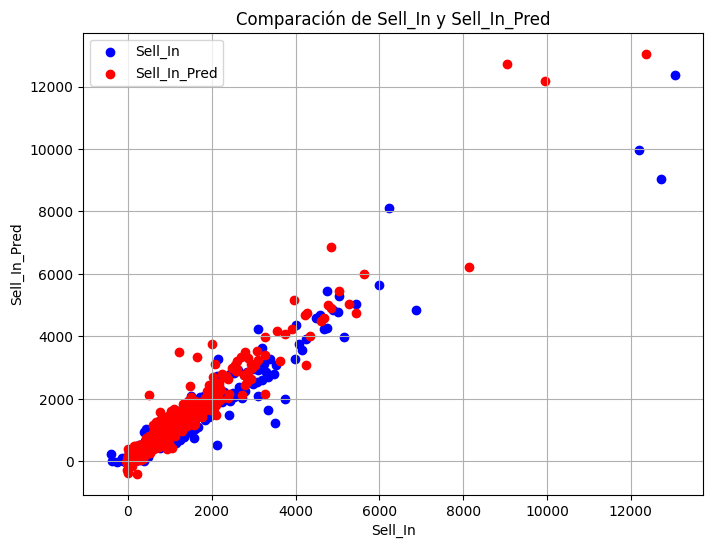

In [24]:
# Gráfico de dispersión
plt.figure(figsize=(8, 6))

plt.scatter(df_analysis['Sell_In'], df_analysis['Sell_In_Pred'], c='blue', label='Sell_In')
plt.scatter(df_analysis['Sell_In_Pred'], df_analysis['Sell_In'], c='red', label='Sell_In_Pred')

plt.xlabel('Sell_In')
plt.ylabel('Sell_In_Pred')
plt.title('Comparación de Sell_In y Sell_In_Pred')
plt.legend()
plt.grid(True)

plt.show()

In [25]:
# Agregar el dato por Fecha, Area y Formato
df_analysis = df_analysis.groupby(['Area_Dist', 'Formato_1', 'Formato_2'], as_index=False) \
                         .sum(['Sell_In', 'Sell_In_Pred'])

# Calcular el error en %
df_analysis['Desviacion'] = round((df_analysis.Sell_In_Pred - df_analysis.Sell_In)*100 / df_analysis.Sell_In, 2)

df_analysis

,Area_Dist,Formato_1,Formato_2,Sell_In,Sell_In_Pred,Desviacion
0,Y0,Barril,Barril,32996.398438,31147.844694,-5.60
1,Y0,No Retornable,Cuarto SR,170.580002,176.886460,3.70
2,Y0,No Retornable,Gran Formato,696.539978,520.027366,-25.34
3,Y0,No Retornable,Lata,3908.100098,2866.024954,-26.66
4,Y0,No Retornable,Medio Litro SR,5.380000,8.032739,49.31
...,...,...,...,...,...,...
80,ZZ,No Retornable,Medio Litro SR,83.599998,70.808398,-15.30
81,ZZ,No Retornable,Quinto SR,50.060001,31.473755,-37.13
82,ZZ,No Retornable,Tercio SR,14518.750000,10088.099262,-30.52
83,ZZ,Retornable,Quinto,1605.060059,1368.068642,-14.77


In [26]:
# Pivot
tabla_desviaciones = df_analysis.pivot_table(index='Area_Dist', columns=['Formato_1', 'Formato_2'], values='Desviacion', aggfunc='mean')

tabla_desviaciones

Formato_1 Barril         No Retornable                                \
Formato_2 Barril Duotank    Bag in Box Cuarto SR Gran Formato   Lata   
Area_Dist                                                              
Y0         -5.60     NaN           NaN      3.70       -25.34 -26.66   
Y1          1.46    2.40        491.77      6.91        22.20  -1.24   
Y2         -4.17   18.12           inf    -21.35        -3.59  -1.55   
Y3         -3.51    5.65           NaN    -24.99        -6.04  -7.02   
Y4         -2.92   10.70          4.70     -9.08         5.67  -7.32   
Y5         -4.02    2.48          2.05     -0.71        12.41   8.40   
Y6         -5.53  -10.34         -1.36    -11.99        -2.13  -5.29   
ZZ        -16.25  -11.86        587.50    -12.69       -10.35 -15.87   

Formato_1                                    Retornable         
Formato_2 Medio Litro SR Quinto SR Tercio SR     Quinto Tercio  
Area_Dist                                                       
Y0                 49.31     78.34      5.87       8.20 -12.58  
Y1                  8.54     38.70    -15.36       0.72   3.20  
Y2                  6.77     25.62    -16.65      -5.18  -4.04  
Y3                 43.45     -7.35    -10.80     -17.02  -6.45  
Y4                 50.72     61.79    -12.29      -4.97  -8.56  
Y5                 12.48    -16.30     -8.35      -5.72  -6.70  
Y6                 16.54     -0.60    -11.45      -6.68  -8.13  
ZZ                -15.30    -37.13    -30.52     -14.77 -18.03

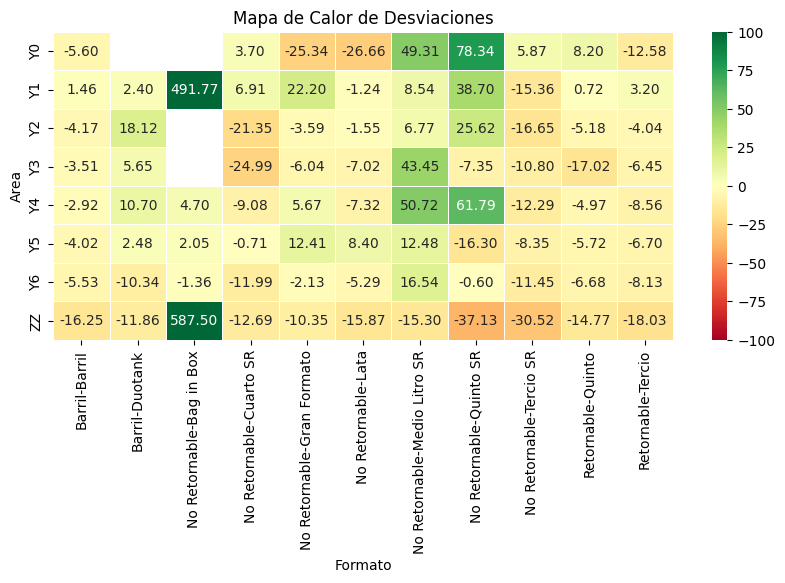

In [27]:
# Cambiar el tamaño del mapa de calor
plt.subplots(figsize=(10, 4))  # Ancho x Alto

# Mapa de calor
sns.heatmap(
    tabla_desviaciones,
    annot=True,
    fmt=".2f",
    cmap='RdYlGn',
    vmin=-100,
    vmax=100,
    linewidth=.5
)

# Mostrar el mapa de calor
plt.title('Mapa de Calor de Desviaciones')
plt.xlabel('Formato')
plt.ylabel('Area')

plt.show()

## 3.2. LightGBM - Modelo Barril

In [28]:
# Medir tiempo
tiempo_inicial = time()


# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato'
run_name = 'Modelo_LightGBM_Experiment_Barril_df06'
model_name = 'lightgbm-model-barril-df06'


# Seed
# ------------------------------------------------------------------------------------
seed = 123


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset
df_exp = df.copy()

# Filtrar por el Formato_1: Global
filtro_formato = (df_exp.Formato_1 == 'Barril')
df_exp = df_exp[filtro_formato]

# Variable dependiente
target = 'Sell_In'

# Variables independientes
features = list(df_exp.columns)
features.remove(target)

# Variables categóricas
categorical_features = [col for col in df_exp.columns if df_exp[col].dtype == 'category']

# Dataset de test y entrenamiento
train, test = train_test_split(df_exp, train_size=0.95, test_size=0.05, random_state=seed)



# MLflow
# ------------------------------------------------------------------------------------
# Activar el experimento
mlflow.set_experiment(experiment_name)

# Lanzar ejecución de MLflow
with mlflow.start_run(run_name=run_name) as run:
    
    # UUID del experimento
    experiment_id = run.info.experiment_id
    
    # UUID de la ejecución
    run_id = run.info.run_uuid
    
    # Instanciar OrdinalEncoder
    encoder = OrdinalEncoder(
        cols=categorical_features,
        handle_unknown="ignore",
        return_df=True
    )

    
    # Parámetros
    params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "n_estimators": 1000,
        "max_depth": 10,
        "num_leaves": 350,
        "min_child_samples": 20,
        "bagging_fraction": 1.0,
        "bagging_freq": 0,
        "feature_fraction": 0.8,
        "reg_sqrt": True,
        "feature_pre_filter": False,
        "random_state": seed,
        "n_jobs": -1
    }
    

    # Instanciar LGBMRegressor
    mlgb = lgb.LGBMRegressor(**params)

    
    # Pipeline: Encoder + Regresor
    model_pipeline = Pipeline([
        ("encoder", encoder),
        ("mlgb", mlgb)
    ])
    
    
    # Entrenar modelo
    model = model_pipeline.fit(train[features], train[target])
    
    
    # Cálculo de métricas
    train_y_real = train[target]
    train_y_pred = model.predict(train[features])

    test_y_real = test[target]
    test_y_pred = model.predict(test[features])

    metric_r2_train = round(r2_score(train_y_real, train_y_pred), 3)
    metric_r2_test = round(r2_score(test_y_real, test_y_pred), 3)

    metric_r2_adj_train = round(1-(1-metric_r2_train)*(len(test)-1)/(len(test)-len(features)-1), 3)
    metric_r2_adj_test = round(1-(1-metric_r2_test)*(len(test)-1)/(len(test)-len(features)-1), 3)

    metric_train_mae = round(mean_absolute_error(train_y_real, train_y_pred), 3)
    metric_test_mae = round(mean_absolute_error(test_y_real, test_y_pred), 3)

    metric_train_rmse = round(mean_squared_error(train_y_real, train_y_pred, squared=False), 3)
    metric_test_rmse = round(mean_squared_error(test_y_real, test_y_pred, squared=False), 3)

    metric_train_score = round(1.00 - (metric_train_mae / train_y_real.mean()), 3)
    metric_test_score = round(1.00 - (metric_test_mae / test_y_real.mean()), 3)
    
    
    # Genere un diccionario con las métricas
    metrics = {
        "r2_train": metric_r2_train,
        "r2_test": metric_r2_test,
        "r2_adj_train": metric_r2_adj_train,
        "r2_adj_test": metric_r2_adj_test,
        "mae_train": metric_train_mae,
        "mae_test": metric_test_mae,
        "rmse_train": metric_train_rmse,
        "rmse_test": metric_test_rmse,
        "score_train": metric_train_score,
        "score_test": metric_test_score
    }
    
    
    # Loggar parámetros
    mlflow.log_params(params)
    
    # Logar métricas
    mlflow.log_metrics(metrics)
    
    # Schema input/output del modelo
    input_schema = Schema([
        ColSpec("string", "Epoca_Covid"),
        ColSpec("string", "Mes"),
        ColSpec("string", "Tipo_Cliente"),
        ColSpec("string", "Area_Dist"),
        ColSpec("string", "ID_Provincia"),
        ColSpec("string", "Gama"),
        ColSpec("string", "Formato_1"),
        ColSpec("string", "Formato_2"),
        ColSpec("double", "Num_PdV_CI"),
        ColSpec("double", "Num_PdV_RU"),
        ColSpec("double", "Num_PdV_TU"),
        ColSpec("double", "Impactos_TV"),
        ColSpec("double", "Sell_In_PP"),
        ColSpec("double", "Marketing_Nacional"),
        ColSpec("double", "Trade_Marketing"),
        ColSpec("double", "Marketing_PLV"),
        ColSpec("double", "Dispersion_PdV"),
        ColSpec("double", "Volumen_Solicitado"),
        ColSpec("double", "Tarifa_Eur_Hl"),
        ColSpec("double", "Margen_Distribuidor"),
        ColSpec("double", "Egatur"),
        ColSpec("double", "Familitur"),
        ColSpec("double", "IPC"),
        ColSpec("double", "IPRI"),
        ColSpec("double", "Temperatura_Media"),
        ColSpec("double", "Precipitacion"),
        ColSpec("double", "Sell_In_1")
    ])
    
    output_schema = Schema([ColSpec("double", "prediction")])
    
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    # Log modelo entrenado
    mlflow.sklearn.log_model(model, model_name, signature=signature)

    
    
    
# Medir tiempo
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial

print('')
print(f"El tiempo de ejecución es de {tiempo_ejecucion/60} minutos")


# Info de la ejecución
print("")
print(f"Modelo loggado en el experimento: {experiment_id} --> {experiment_name}")
print(f"Modelo loggado en la ejecución: {run_id} --> {run_name}")
print(f"Nombre del modelo: {model_name}")
print(f"Modelo URI: 'runs:/{run_id}/{model_name}'")

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0

El tiempo de ejecución es de 0.642981739838918 minutos

Modelo loggado en el experimento: 766905929124975051 --> MSM_Sell_In_Modelos_Formato
Modelo loggado en la ejecución: 5e23bf5b2f7442908cd1fcae4aedb577 --> Modelo_LightGBM_Experiment_Barril_df06
Nombre del modelo: lightgbm-model-barril-df06
Modelo URI: 'runs:/5e23bf5b2f7442908cd1fcae4aedb577/lightgbm-model-barril-df06'


/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [29]:
logged_model_lgb_barril = f'runs:/{run_id}/{model_name}'
logged_model_lgb_barril

'runs:/5e23bf5b2f7442908cd1fcae4aedb577/lightgbm-model-barril-df06'

### 3.2.1. Predicciones último mes

In [30]:
# Dataset para comprobar predicciones
df_val.head()

,Fecha,Fecha_Date,Epoca_Covid,Anio,Trimestre,Mes,Cliente,Tipo_Cliente,Distribuidor_MSM,Codigo_Postal,...,Temperatura_Minima,Temperatura_Media,Temperatura_Maxima,Precipitacion,Sell_In_3,Sell_In_2,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.59,0.49,0.34,0.66,2024-03-07T13:35:13.804Z,202403
1,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.55,0.48,0.32,0.48,2024-03-07T13:35:13.804Z,202403
2,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,8.50,10.50,6.00,6.00,2024-03-07T13:35:13.804Z,202403
3,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.12,0.18,0.12,0.18,2024-03-07T13:35:13.804Z,202403
4,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.00,0.08,0.00,0.00,2024-03-07T13:35:13.804Z,202403


In [31]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104676 entries, 0 to 104675
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fecha                       104676 non-null  int32  
 1   Fecha_Date                  104676 non-null  object 
 2   Epoca_Covid                 104676 non-null  object 
 3   Anio                        104676 non-null  object 
 4   Trimestre                   104676 non-null  object 
 5   Mes                         104676 non-null  object 
 6   Cliente                     104676 non-null  object 
 7   Tipo_Cliente                104676 non-null  object 
 8   Distribuidor_MSM            104676 non-null  object 
 9   Codigo_Postal               104676 non-null  object 
 10  Area_Dist                   104676 non-null  object 
 11  Zona                        104676 non-null  object 
 12  ID_Provincia                104676 non-null  object 
 13  Provincia     

In [32]:
# Filtrar Formato_1
filtro_formato = (df_val.Formato_1 == 'Barril')
df_val_exp = df_val[filtro_formato].reset_index(drop=True)

# Castear las columnas de tipo category a object
categorical_columns = df_val_exp.select_dtypes(include=['category']).columns
df_val_exp[categorical_columns] = df_val_exp[categorical_columns].astype('object')

In [33]:
# Lista de variables dependientes
print(features)

['Epoca_Covid', 'Mes', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Sell_In_1']


In [34]:
# Cargar modelo como PyFuncModel.
print(logged_model_lgb_barril)
loaded_model_lgb = mlflow.pyfunc.load_model(logged_model_lgb_barril)

# Prediccion
predictions = pd.Series(loaded_model_lgb.predict(df_val_exp[features]), name='Sell_In_Pred')

runs:/5e23bf5b2f7442908cd1fcae4aedb577/lightgbm-model-barril-df06


In [35]:
# Columnas del análisis
df_analysis = df_val_exp[['Area_Dist', 'Formato_1', 'Formato_2', 'Sell_In']]

# Concatenar dataset anterior con las predicciones
df_analysis = pd.concat([df_analysis, predictions], axis=1)

df_analysis.head()

,Area_Dist,Formato_1,Formato_2,Sell_In,Sell_In_Pred
0,ZZ,Barril,Barril,6.0,1.689656
1,ZZ,Barril,Barril,2.7,0.492499
2,ZZ,Barril,Barril,2.7,0.654527
3,ZZ,Barril,Barril,3.0,0.356052
4,ZZ,Barril,Barril,2.7,0.613054


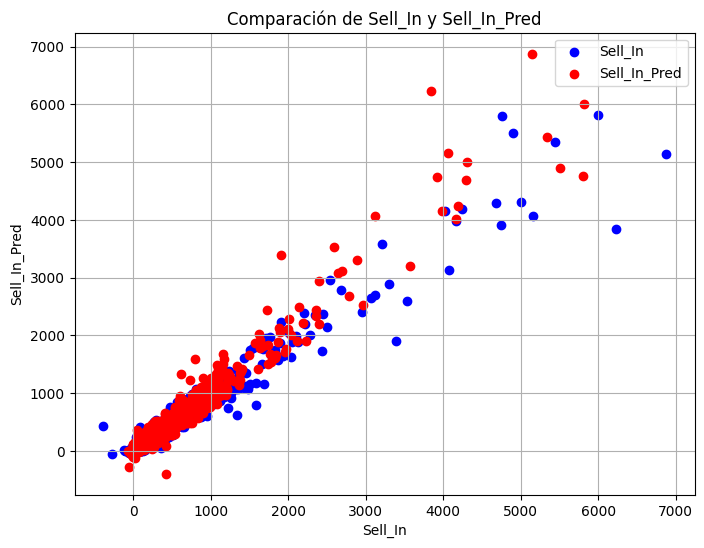

In [36]:
# Gráfico de dispersión
plt.figure(figsize=(8, 6))

plt.scatter(df_analysis['Sell_In'], df_analysis['Sell_In_Pred'], c='blue', label='Sell_In')
plt.scatter(df_analysis['Sell_In_Pred'], df_analysis['Sell_In'], c='red', label='Sell_In_Pred')

plt.xlabel('Sell_In')
plt.ylabel('Sell_In_Pred')
plt.title('Comparación de Sell_In y Sell_In_Pred')
plt.legend()
plt.grid(True)

plt.show()

In [37]:
# Agregar el dato por Fecha, Area y Formato
df_analysis = df_analysis.groupby(['Area_Dist', 'Formato_1', 'Formato_2'], as_index=False) \
                         .sum(['Sell_In', 'Sell_In_Pred'])

# Calcular el error en %
df_analysis['Desviacion'] = round((df_analysis.Sell_In_Pred - df_analysis.Sell_In)*100 / df_analysis.Sell_In, 2)

df_analysis

,Area_Dist,Formato_1,Formato_2,Sell_In,Sell_In_Pred,Desviacion
0,Y0,Barril,Barril,32996.398438,28643.221002,-13.19
1,Y1,Barril,Barril,71751.601562,68881.699624,-4.00
2,Y1,Barril,Duotank,2487.189941,2621.098492,5.38
3,Y2,Barril,Barril,87604.203125,84099.291107,-4.00
4,Y2,Barril,Duotank,1189.119995,1356.286546,14.06
5,Y3,Barril,Barril,103156.398438,94431.002623,-8.46
6,Y3,Barril,Duotank,1454.400024,1521.739472,4.63
7,Y4,Barril,Barril,55604.300781,54946.016148,-1.18
8,Y4,Barril,Duotank,1182.660034,1305.234891,10.36
9,Y5,Barril,Barril,124441.500000,123075.648194,-1.10


In [38]:
# Pivot
tabla_desviaciones = df_analysis.pivot_table(index='Area_Dist', columns=['Formato_1', 'Formato_2'], values='Desviacion', aggfunc='mean')

tabla_desviaciones

Formato_1 Barril        
Formato_2 Barril Duotank
Area_Dist               
Y0        -13.19     NaN
Y1         -4.00    5.38
Y2         -4.00   14.06
Y3         -8.46    4.63
Y4         -1.18   10.36
Y5         -1.10    3.80
Y6         -3.38  -15.64
ZZ        -13.14    1.74

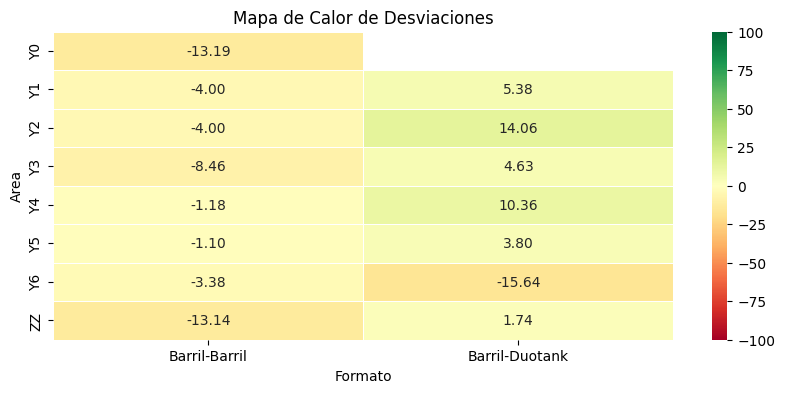

In [39]:
# Cambiar el tamaño del mapa de calor
plt.subplots(figsize=(10, 4))  # Ancho x Alto

# Mapa de calor
sns.heatmap(
    tabla_desviaciones,
    annot=True,
    fmt=".2f",
    cmap='RdYlGn',
    vmin=-100,
    vmax=100,
    linewidth=.5
)

# Mostrar el mapa de calor
plt.title('Mapa de Calor de Desviaciones')
plt.xlabel('Formato')
plt.ylabel('Area')

plt.show()

## 3.3. LightGBM - Modelo Retornable

In [40]:
# Medir tiempo
tiempo_inicial = time()


# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato'
run_name = 'Modelo_LightGBM_Experiment_Retornable_df06'
model_name = 'lightgbm-model-ret-df06'


# Seed
# ------------------------------------------------------------------------------------
seed = 123


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset
df_exp = df.copy()

# Filtrar por el Formato_1: Global
filtro_formato = (df_exp.Formato_1 == 'Retornable')
df_exp = df_exp[filtro_formato]

# Variable dependiente
target = 'Sell_In'

# Variables independientes
features = list(df_exp.columns)
features.remove(target)

# Variables categóricas
categorical_features = [col for col in df_exp.columns if df_exp[col].dtype == 'category']

# Dataset de test y entrenamiento
train, test = train_test_split(df_exp, train_size=0.95, test_size=0.05, random_state=seed)



# MLflow
# ------------------------------------------------------------------------------------
# Activar el experimento
mlflow.set_experiment(experiment_name)

# Lanzar ejecución de MLflow
with mlflow.start_run(run_name=run_name) as run:
    
    # UUID del experimento
    experiment_id = run.info.experiment_id
    
    # UUID de la ejecución
    run_id = run.info.run_uuid
    
    # Instanciar OrdinalEncoder
    encoder = OrdinalEncoder(
        cols=categorical_features,
        handle_unknown="ignore",
        return_df=True
    )

    
    # Parámetros
    params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "n_estimators": 1000,
        "max_depth": 10,
        "num_leaves": 350,
        "min_child_samples": 20,
        "bagging_fraction": 1.0,
        "bagging_freq": 0,
        "feature_fraction": 0.8,
        "reg_sqrt": True,
        "feature_pre_filter": False,
        "random_state": seed,
        "n_jobs": -1
    }
    

    # Instanciar LGBMRegressor
    mlgb = lgb.LGBMRegressor(**params)

    
    # Pipeline: Encoder + Regresor
    model_pipeline = Pipeline([
        ("encoder", encoder),
        ("mlgb", mlgb)
    ])
    
    
    # Entrenar modelo
    model = model_pipeline.fit(train[features], train[target])
    
    
    # Cálculo de métricas
    train_y_real = train[target]
    train_y_pred = model.predict(train[features])

    test_y_real = test[target]
    test_y_pred = model.predict(test[features])

    metric_r2_train = round(r2_score(train_y_real, train_y_pred), 3)
    metric_r2_test = round(r2_score(test_y_real, test_y_pred), 3)

    metric_r2_adj_train = round(1-(1-metric_r2_train)*(len(test)-1)/(len(test)-len(features)-1), 3)
    metric_r2_adj_test = round(1-(1-metric_r2_test)*(len(test)-1)/(len(test)-len(features)-1), 3)

    metric_train_mae = round(mean_absolute_error(train_y_real, train_y_pred), 3)
    metric_test_mae = round(mean_absolute_error(test_y_real, test_y_pred), 3)

    metric_train_rmse = round(mean_squared_error(train_y_real, train_y_pred, squared=False), 3)
    metric_test_rmse = round(mean_squared_error(test_y_real, test_y_pred, squared=False), 3)

    metric_train_score = round(1.00 - (metric_train_mae / train_y_real.mean()), 3)
    metric_test_score = round(1.00 - (metric_test_mae / test_y_real.mean()), 3)
    
    
    # Genere un diccionario con las métricas
    metrics = {
        "r2_train": metric_r2_train,
        "r2_test": metric_r2_test,
        "r2_adj_train": metric_r2_adj_train,
        "r2_adj_test": metric_r2_adj_test,
        "mae_train": metric_train_mae,
        "mae_test": metric_test_mae,
        "rmse_train": metric_train_rmse,
        "rmse_test": metric_test_rmse,
        "score_train": metric_train_score,
        "score_test": metric_test_score
    }
    
    
    # Loggar parámetros
    mlflow.log_params(params)
    
    # Logar métricas
    mlflow.log_metrics(metrics)
    
    # Schema input/output del modelo
    input_schema = Schema([
        ColSpec("string", "Epoca_Covid"),
        ColSpec("string", "Mes"),
        ColSpec("string", "Tipo_Cliente"),
        ColSpec("string", "Area_Dist"),
        ColSpec("string", "ID_Provincia"),
        ColSpec("string", "Gama"),
        ColSpec("string", "Formato_1"),
        ColSpec("string", "Formato_2"),
        ColSpec("double", "Num_PdV_CI"),
        ColSpec("double", "Num_PdV_RU"),
        ColSpec("double", "Num_PdV_TU"),
        ColSpec("double", "Impactos_TV"),
        ColSpec("double", "Sell_In_PP"),
        ColSpec("double", "Marketing_Nacional"),
        ColSpec("double", "Trade_Marketing"),
        ColSpec("double", "Marketing_PLV"),
        ColSpec("double", "Dispersion_PdV"),
        ColSpec("double", "Volumen_Solicitado"),
        ColSpec("double", "Tarifa_Eur_Hl"),
        ColSpec("double", "Margen_Distribuidor"),
        ColSpec("double", "Egatur"),
        ColSpec("double", "Familitur"),
        ColSpec("double", "IPC"),
        ColSpec("double", "IPRI"),
        ColSpec("double", "Temperatura_Media"),
        ColSpec("double", "Precipitacion"),
        ColSpec("double", "Sell_In_1")
    ])
    
    output_schema = Schema([ColSpec("double", "prediction")])
    
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    # Log modelo entrenado
    mlflow.sklearn.log_model(model, model_name, signature=signature)

    
    
    
# Medir tiempo
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial

print('')
print(f"El tiempo de ejecución es de {tiempo_ejecucion/60} minutos")


# Info de la ejecución
print("")
print(f"Modelo loggado en el experimento: {experiment_id} --> {experiment_name}")
print(f"Modelo loggado en la ejecución: {run_id} --> {run_name}")
print(f"Nombre del modelo: {model_name}")
print(f"Modelo URI: 'runs:/{run_id}/{model_name}'")

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0

El tiempo de ejecución es de 0.6099574605623881 minutos

Modelo loggado en el experimento: 766905929124975051 --> MSM_Sell_In_Modelos_Formato
Modelo loggado en la ejecución: 8a5845f150b541c384b48004766a49bb --> Modelo_LightGBM_Experiment_Retornable_df06
Nombre del modelo: lightgbm-model-ret-df06
Modelo URI: 'runs:/8a5845f150b541c384b48004766a49bb/lightgbm-model-ret-df06'


/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [41]:
logged_model_lgb_retornable = f'runs:/{run_id}/{model_name}'
logged_model_lgb_retornable

'runs:/8a5845f150b541c384b48004766a49bb/lightgbm-model-ret-df06'

### 3.3.1. Predicciones último mes

In [42]:
# Dataset para comprobar predicciones
df_val.head()

,Fecha,Fecha_Date,Epoca_Covid,Anio,Trimestre,Mes,Cliente,Tipo_Cliente,Distribuidor_MSM,Codigo_Postal,...,Temperatura_Minima,Temperatura_Media,Temperatura_Maxima,Precipitacion,Sell_In_3,Sell_In_2,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.59,0.49,0.34,0.66,2024-03-07T13:35:13.804Z,202403
1,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.55,0.48,0.32,0.48,2024-03-07T13:35:13.804Z,202403
2,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,8.50,10.50,6.00,6.00,2024-03-07T13:35:13.804Z,202403
3,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.12,0.18,0.12,0.18,2024-03-07T13:35:13.804Z,202403
4,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.00,0.08,0.00,0.00,2024-03-07T13:35:13.804Z,202403


In [43]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104676 entries, 0 to 104675
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fecha                       104676 non-null  int32  
 1   Fecha_Date                  104676 non-null  object 
 2   Epoca_Covid                 104676 non-null  object 
 3   Anio                        104676 non-null  object 
 4   Trimestre                   104676 non-null  object 
 5   Mes                         104676 non-null  object 
 6   Cliente                     104676 non-null  object 
 7   Tipo_Cliente                104676 non-null  object 
 8   Distribuidor_MSM            104676 non-null  object 
 9   Codigo_Postal               104676 non-null  object 
 10  Area_Dist                   104676 non-null  object 
 11  Zona                        104676 non-null  object 
 12  ID_Provincia                104676 non-null  object 
 13  Provincia     

In [44]:
# Filtrar Formato_1
filtro_formato = (df_val.Formato_1 == 'Retornable')
df_val_exp = df_val[filtro_formato].reset_index(drop=True)

# Castear las columnas de tipo category a object
categorical_columns = df_val_exp.select_dtypes(include=['category']).columns
df_val_exp[categorical_columns] = df_val_exp[categorical_columns].astype('object')

In [45]:
# Lista de variables dependientes
print(features)

['Epoca_Covid', 'Mes', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Sell_In_1']


In [46]:
# Cargar modelo como PyFuncModel.
print(logged_model_lgb_retornable)
loaded_model_lgb = mlflow.pyfunc.load_model(logged_model_lgb_retornable)

# Prediccion
predictions = pd.Series(loaded_model_lgb.predict(df_val_exp[features]), name='Sell_In_Pred')

runs:/8a5845f150b541c384b48004766a49bb/lightgbm-model-ret-df06


In [47]:
# Columnas del análisis
df_analysis = df_val_exp[['Area_Dist', 'Formato_1', 'Formato_2', 'Sell_In']]

# Concatenar dataset anterior con las predicciones
df_analysis = pd.concat([df_analysis, predictions], axis=1)

df_analysis.head()

,Area_Dist,Formato_1,Formato_2,Sell_In,Sell_In_Pred
0,ZZ,Retornable,Tercio,0.00,0.000067
1,ZZ,Retornable,Tercio,0.16,0.177939
2,ZZ,Retornable,Tercio,0.00,0.025266
3,ZZ,Retornable,Tercio,0.00,0.048637
4,ZZ,Retornable,Tercio,0.24,0.150949


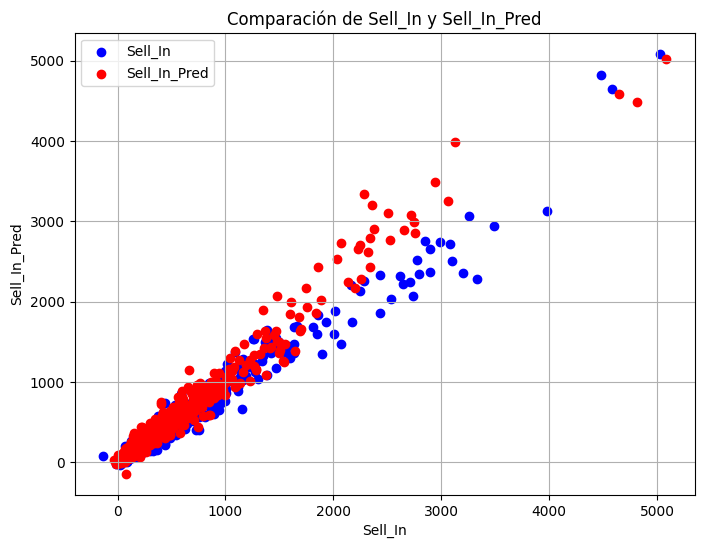

In [48]:
# Gráfico de dispersión
plt.figure(figsize=(8, 6))

plt.scatter(df_analysis['Sell_In'], df_analysis['Sell_In_Pred'], c='blue', label='Sell_In')
plt.scatter(df_analysis['Sell_In_Pred'], df_analysis['Sell_In'], c='red', label='Sell_In_Pred')

plt.xlabel('Sell_In')
plt.ylabel('Sell_In_Pred')
plt.title('Comparación de Sell_In y Sell_In_Pred')
plt.legend()
plt.grid(True)

plt.show()

In [49]:
# Agregar el dato por Fecha, Area y Formato
df_analysis = df_analysis.groupby(['Area_Dist', 'Formato_1', 'Formato_2'], as_index=False) \
                         .sum(['Sell_In', 'Sell_In_Pred'])

# Calcular el error en %
df_analysis['Desviacion'] = round((df_analysis.Sell_In_Pred - df_analysis.Sell_In)*100 / df_analysis.Sell_In, 2)

df_analysis

,Area_Dist,Formato_1,Formato_2,Sell_In,Sell_In_Pred,Desviacion
0,Y0,Retornable,Quinto,103.020004,89.107607,-13.50
1,Y0,Retornable,Tercio,1751.260010,1517.958289,-13.32
2,Y1,Retornable,Quinto,5077.560059,4861.040885,-4.26
3,Y1,Retornable,Tercio,52952.558594,53401.425864,0.85
4,Y2,Retornable,Quinto,16853.160156,16152.259649,-4.16
5,Y2,Retornable,Tercio,100745.937500,95755.913089,-4.95
6,Y3,Retornable,Quinto,4654.919922,4213.710102,-9.48
7,Y3,Retornable,Tercio,71711.648438,66304.903301,-7.54
8,Y4,Retornable,Quinto,45922.679688,43685.266959,-4.87
9,Y4,Retornable,Tercio,48337.992188,43939.608707,-9.10


In [50]:
# Pivot
tabla_desviaciones = df_analysis.pivot_table(index='Area_Dist', columns=['Formato_1', 'Formato_2'], values='Desviacion', aggfunc='mean')

tabla_desviaciones

Formato_1 Retornable       
Formato_2     Quinto Tercio
Area_Dist                  
Y0            -13.50 -13.32
Y1             -4.26   0.85
Y2             -4.16  -4.95
Y3             -9.48  -7.54
Y4             -4.87  -9.10
Y5             -0.29  -6.27
Y6             -8.13 -11.94
ZZ            -16.81 -18.18

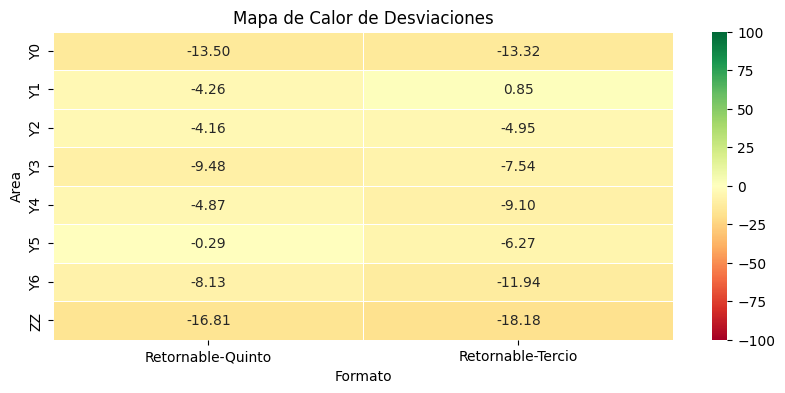

In [51]:
# Cambiar el tamaño del mapa de calor
plt.subplots(figsize=(10, 4))  # Ancho x Alto

# Mapa de calor
sns.heatmap(
    tabla_desviaciones,
    annot=True,
    fmt=".2f",
    cmap='RdYlGn',
    vmin=-100,
    vmax=100,
    linewidth=.5
)

# Mostrar el mapa de calor
plt.title('Mapa de Calor de Desviaciones')
plt.xlabel('Formato')
plt.ylabel('Area')

plt.show()

## 3.4. LightGBM - Modelo No Retornable

In [52]:
# Medir tiempo
tiempo_inicial = time()


# Variables de ejecución MLflow
# ------------------------------------------------------------------------------------
experiment_name = 'MSM_Sell_In_Modelos_Formato'
run_name = 'Modelo_LightGBM_Experiment_No_Retornable_df06'
model_name = 'lightgbm-model-no-ret-df06'


# Seed
# ------------------------------------------------------------------------------------
seed = 123


# Dataset de test y entrenamiento
# ------------------------------------------------------------------------------------
# Copia del dataset
df_exp = df.copy()

# Filtrar por el Formato_1: Global
filtro_formato = (df_exp.Formato_1 == 'No Retornable')
df_exp = df_exp[filtro_formato]

# Variable dependiente
target = 'Sell_In'

# Variables independientes
features = list(df_exp.columns)
features.remove(target)

# Variables categóricas
categorical_features = [col for col in df_exp.columns if df_exp[col].dtype == 'category']

# Dataset de test y entrenamiento
train, test = train_test_split(df_exp, train_size=0.95, test_size=0.05, random_state=seed)



# MLflow
# ------------------------------------------------------------------------------------
# Activar el experimento
mlflow.set_experiment(experiment_name)

# Lanzar ejecución de MLflow
with mlflow.start_run(run_name=run_name) as run:
    
    # UUID del experimento
    experiment_id = run.info.experiment_id
    
    # UUID de la ejecución
    run_id = run.info.run_uuid
    
    # Instanciar OrdinalEncoder
    encoder = OrdinalEncoder(
        cols=categorical_features,
        handle_unknown="ignore",
        return_df=True
    )

    
    # Parámetros
    params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "n_estimators": 1000,
        "max_depth": 10,
        "num_leaves": 350,
        "min_child_samples": 20,
        "bagging_fraction": 1.0,
        "bagging_freq": 0,
        "feature_fraction": 0.8,
        "reg_sqrt": True,
        "feature_pre_filter": False,
        "random_state": seed,
        "n_jobs": -1
    }
    

    # Instanciar LGBMRegressor
    mlgb = lgb.LGBMRegressor(**params)

    
    # Pipeline: Encoder + Regresor
    model_pipeline = Pipeline([
        ("encoder", encoder),
        ("mlgb", mlgb)
    ])
    
    
    # Entrenar modelo
    model = model_pipeline.fit(train[features], train[target])
    
    
    # Cálculo de métricas
    train_y_real = train[target]
    train_y_pred = model.predict(train[features])

    test_y_real = test[target]
    test_y_pred = model.predict(test[features])

    metric_r2_train = round(r2_score(train_y_real, train_y_pred), 3)
    metric_r2_test = round(r2_score(test_y_real, test_y_pred), 3)

    metric_r2_adj_train = round(1-(1-metric_r2_train)*(len(test)-1)/(len(test)-len(features)-1), 3)
    metric_r2_adj_test = round(1-(1-metric_r2_test)*(len(test)-1)/(len(test)-len(features)-1), 3)

    metric_train_mae = round(mean_absolute_error(train_y_real, train_y_pred), 3)
    metric_test_mae = round(mean_absolute_error(test_y_real, test_y_pred), 3)

    metric_train_rmse = round(mean_squared_error(train_y_real, train_y_pred, squared=False), 3)
    metric_test_rmse = round(mean_squared_error(test_y_real, test_y_pred, squared=False), 3)

    metric_train_score = round(1.00 - (metric_train_mae / train_y_real.mean()), 3)
    metric_test_score = round(1.00 - (metric_test_mae / test_y_real.mean()), 3)
    
    
    # Genere un diccionario con las métricas
    metrics = {
        "r2_train": metric_r2_train,
        "r2_test": metric_r2_test,
        "r2_adj_train": metric_r2_adj_train,
        "r2_adj_test": metric_r2_adj_test,
        "mae_train": metric_train_mae,
        "mae_test": metric_test_mae,
        "rmse_train": metric_train_rmse,
        "rmse_test": metric_test_rmse,
        "score_train": metric_train_score,
        "score_test": metric_test_score
    }
    
    
    # Loggar parámetros
    mlflow.log_params(params)
    
    # Logar métricas
    mlflow.log_metrics(metrics)
    
    # Schema input/output del modelo
    input_schema = Schema([
        ColSpec("string", "Epoca_Covid"),
        ColSpec("string", "Mes"),
        ColSpec("string", "Tipo_Cliente"),
        ColSpec("string", "Area_Dist"),
        ColSpec("string", "ID_Provincia"),
        ColSpec("string", "Gama"),
        ColSpec("string", "Formato_1"),
        ColSpec("string", "Formato_2"),
        ColSpec("double", "Num_PdV_CI"),
        ColSpec("double", "Num_PdV_RU"),
        ColSpec("double", "Num_PdV_TU"),
        ColSpec("double", "Impactos_TV"),
        ColSpec("double", "Sell_In_PP"),
        ColSpec("double", "Marketing_Nacional"),
        ColSpec("double", "Trade_Marketing"),
        ColSpec("double", "Marketing_PLV"),
        ColSpec("double", "Dispersion_PdV"),
        ColSpec("double", "Volumen_Solicitado"),
        ColSpec("double", "Tarifa_Eur_Hl"),
        ColSpec("double", "Margen_Distribuidor"),
        ColSpec("double", "Egatur"),
        ColSpec("double", "Familitur"),
        ColSpec("double", "IPC"),
        ColSpec("double", "IPRI"),
        ColSpec("double", "Temperatura_Media"),
        ColSpec("double", "Precipitacion"),
        ColSpec("double", "Sell_In_1")
    ])
    
    output_schema = Schema([ColSpec("double", "prediction")])
    
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    # Log modelo entrenado
    mlflow.sklearn.log_model(model, model_name, signature=signature)

    
    
    
# Medir tiempo
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial

print('')
print(f"El tiempo de ejecución es de {tiempo_ejecucion/60} minutos")


# Info de la ejecución
print("")
print(f"Modelo loggado en el experimento: {experiment_id} --> {experiment_name}")
print(f"Modelo loggado en la ejecución: {run_id} --> {run_name}")
print(f"Nombre del modelo: {model_name}")
print(f"Modelo URI: 'runs:/{run_id}/{model_name}'")

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0

El tiempo de ejecución es de 1.4041616797447205 minutos

Modelo loggado en el experimento: 766905929124975051 --> MSM_Sell_In_Modelos_Formato
Modelo loggado en la ejecución: 75158acce18f4c208dea3ed36aac2709 --> Modelo_LightGBM_Experiment_No_Retornable_df06
Nombre del modelo: lightgbm-model-no-ret-df06
Modelo URI: 'runs:/75158acce18f4c208dea3ed36aac2709/lightgbm-model-no-ret-df06'


/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/gmachin/.cache/pypoetry/virtualenvs/msm-sell-in-prediction-unVKpS6j-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [53]:
logged_model_lgb_no_ret = f'runs:/{run_id}/{model_name}'
logged_model_lgb_no_ret

'runs:/75158acce18f4c208dea3ed36aac2709/lightgbm-model-no-ret-df06'

### 3.4.1. Predicciones último mes

In [54]:
# Dataset para comprobar predicciones
df_val.head()

,Fecha,Fecha_Date,Epoca_Covid,Anio,Trimestre,Mes,Cliente,Tipo_Cliente,Distribuidor_MSM,Codigo_Postal,...,Temperatura_Minima,Temperatura_Media,Temperatura_Maxima,Precipitacion,Sell_In_3,Sell_In_2,Sell_In_1,Sell_In,STRATIO_CREATED_DATE,exec_month
0,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.59,0.49,0.34,0.66,2024-03-07T13:35:13.804Z,202403
1,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.55,0.48,0.32,0.48,2024-03-07T13:35:13.804Z,202403
2,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,8.50,10.50,6.00,6.00,2024-03-07T13:35:13.804Z,202403
3,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.12,0.18,0.12,0.18,2024-03-07T13:35:13.804Z,202403
4,202310,2023-10-01,post-covid,2023,T4,10,534588,DHC,0,28906,...,12.22,17.33,22.440001,154.460007,0.00,0.08,0.00,0.00,2024-03-07T13:35:13.804Z,202403


In [55]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104676 entries, 0 to 104675
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fecha                       104676 non-null  int32  
 1   Fecha_Date                  104676 non-null  object 
 2   Epoca_Covid                 104676 non-null  object 
 3   Anio                        104676 non-null  object 
 4   Trimestre                   104676 non-null  object 
 5   Mes                         104676 non-null  object 
 6   Cliente                     104676 non-null  object 
 7   Tipo_Cliente                104676 non-null  object 
 8   Distribuidor_MSM            104676 non-null  object 
 9   Codigo_Postal               104676 non-null  object 
 10  Area_Dist                   104676 non-null  object 
 11  Zona                        104676 non-null  object 
 12  ID_Provincia                104676 non-null  object 
 13  Provincia     

In [56]:
# Filtrar Formato_1
filtro_formato = (df_val.Formato_1 == 'No Retornable')
df_val_exp = df_val[filtro_formato].reset_index(drop=True)

# Castear las columnas de tipo category a object
categorical_columns = df_val_exp.select_dtypes(include=['category']).columns
df_val_exp[categorical_columns] = df_val_exp[categorical_columns].astype('object')

In [57]:
# Lista de variables dependientes
print(features)

['Epoca_Covid', 'Mes', 'Tipo_Cliente', 'Area_Dist', 'ID_Provincia', 'Gama', 'Formato_1', 'Formato_2', 'Num_PdV_CI', 'Num_PdV_RU', 'Num_PdV_TU', 'Impactos_TV', 'Sell_In_PP', 'Marketing_Nacional', 'Trade_Marketing', 'Marketing_PLV', 'Dispersion_PdV', 'Volumen_Solicitado', 'Tarifa_Eur_Hl', 'Margen_Distribuidor', 'Egatur', 'Familitur', 'IPC', 'IPRI', 'Temperatura_Media', 'Precipitacion', 'Sell_In_1']


In [58]:
# Cargar modelo como PyFuncModel.
print(logged_model_lgb_no_ret)
loaded_model_lgb = mlflow.pyfunc.load_model(logged_model_lgb_no_ret)

# Prediccion
predictions = pd.Series(loaded_model_lgb.predict(df_val_exp[features]), name='Sell_In_Pred')

runs:/75158acce18f4c208dea3ed36aac2709/lightgbm-model-no-ret-df06


In [59]:
# Columnas del análisis
df_analysis = df_val_exp[['Area_Dist', 'Formato_1', 'Formato_2', 'Sell_In']]

# Concatenar dataset anterior con las predicciones
df_analysis = pd.concat([df_analysis, predictions], axis=1)

df_analysis.head()

,Area_Dist,Formato_1,Formato_2,Sell_In,Sell_In_Pred
0,ZZ,No Retornable,Tercio SR,0.66,0.133526
1,ZZ,No Retornable,Tercio SR,0.48,0.030027
2,ZZ,No Retornable,Cuarto SR,0.18,0.019426
3,ZZ,No Retornable,Lata,0.00,-0.000011
4,ZZ,No Retornable,Tercio SR,1.58,0.406198


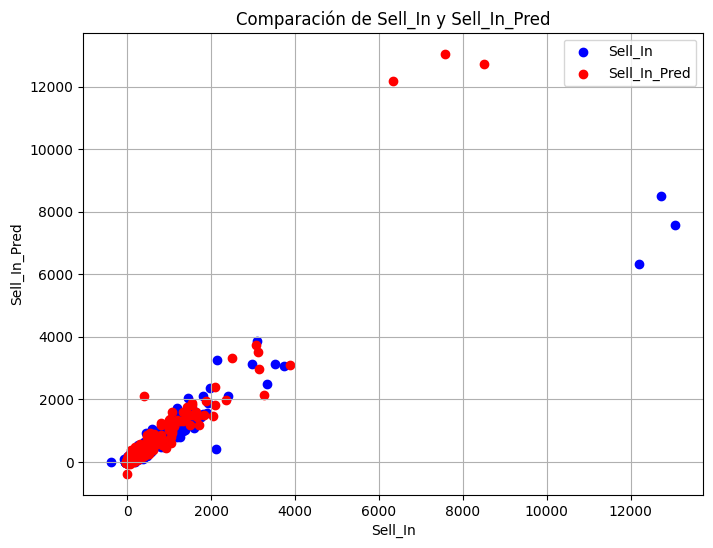

In [60]:
# Gráfico de dispersión
plt.figure(figsize=(8, 6))

plt.scatter(df_analysis['Sell_In'], df_analysis['Sell_In_Pred'], c='blue', label='Sell_In')
plt.scatter(df_analysis['Sell_In_Pred'], df_analysis['Sell_In'], c='red', label='Sell_In_Pred')

plt.xlabel('Sell_In')
plt.ylabel('Sell_In_Pred')
plt.title('Comparación de Sell_In y Sell_In_Pred')
plt.legend()
plt.grid(True)

plt.show()

In [61]:
# Agregar el dato por Fecha, Area y Formato
df_analysis = df_analysis.groupby(['Area_Dist', 'Formato_1', 'Formato_2'], as_index=False) \
                         .sum(['Sell_In', 'Sell_In_Pred'])

# Calcular el error en %
df_analysis['Desviacion'] = round((df_analysis.Sell_In_Pred - df_analysis.Sell_In)*100 / df_analysis.Sell_In, 2)

df_analysis

,Area_Dist,Formato_1,Formato_2,Sell_In,Sell_In_Pred,Desviacion
0,Y0,No Retornable,Cuarto SR,170.580002,191.195529,12.09
1,Y0,No Retornable,Gran Formato,696.539978,516.270191,-25.88
2,Y0,No Retornable,Lata,3908.100098,3095.635115,-20.79
3,Y0,No Retornable,Medio Litro SR,5.380000,10.983024,104.15
4,Y0,No Retornable,Quinto SR,120.879997,155.443385,28.59
5,Y0,No Retornable,Tercio SR,2003.119995,2053.068645,2.49
6,Y1,No Retornable,Bag in Box,1.799999,14.985246,732.51
7,Y1,No Retornable,Cuarto SR,694.830017,750.362852,7.99
8,Y1,No Retornable,Gran Formato,1267.700073,1576.841664,24.39
9,Y1,No Retornable,Lata,8134.020020,8277.213559,1.76


In [62]:
# Pivot
tabla_desviaciones = df_analysis.pivot_table(index='Area_Dist', columns=['Formato_1', 'Formato_2'], values='Desviacion', aggfunc='mean')

tabla_desviaciones

Formato_1 No Retornable                                               \
Formato_2    Bag in Box Cuarto SR Gran Formato   Lata Medio Litro SR   
Area_Dist                                                              
Y0                  NaN     12.09       -25.88 -20.79         104.15   
Y1               732.51      7.99        24.39   1.76          14.09   
Y2                 -inf    -20.42         0.08  -5.20          -6.56   
Y3                  NaN    -26.06        12.16   5.40          41.68   
Y4                56.52    -10.67         3.69 -12.85          25.97   
Y5                -1.79      1.21         5.80  13.90          16.65   
Y6                29.24     -5.07        -2.58  -7.59           7.20   
ZZ               719.29    -20.04       -13.42 -22.47         -18.20   

Formato_1                      
Formato_2 Quinto SR Tercio SR  
Area_Dist                      
Y0            28.59      2.49  
Y1            37.33    -11.79  
Y2            12.26    -13.95  
Y3           -11.82     -6.16  
Y4            33.98     -9.75  
Y5           -15.01     -1.24  
Y6             0.51     -8.35  
ZZ           -45.35    -25.71

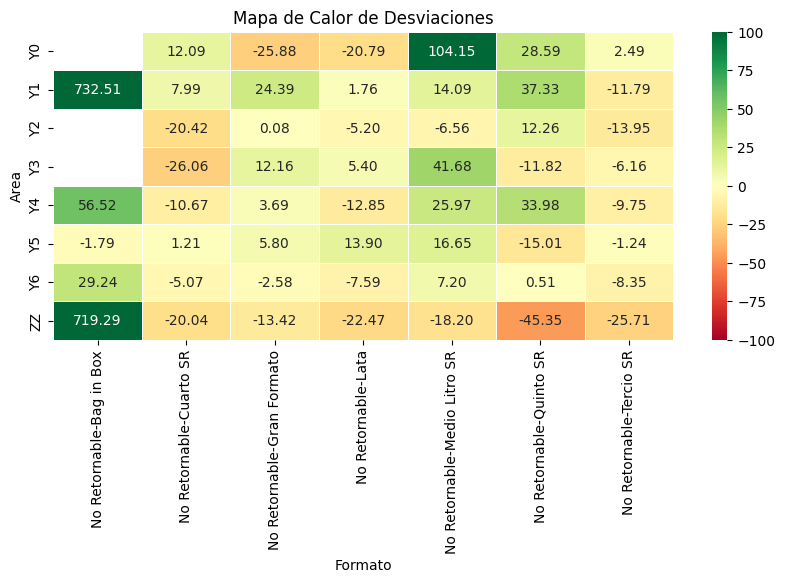

In [63]:
# Cambiar el tamaño del mapa de calor
plt.subplots(figsize=(10, 4))  # Ancho x Alto

# Mapa de calor
sns.heatmap(
    tabla_desviaciones,
    annot=True,
    fmt=".2f",
    cmap='RdYlGn',
    vmin=-100,
    vmax=100,
    linewidth=.5
)

# Mostrar el mapa de calor
plt.title('Mapa de Calor de Desviaciones')
plt.xlabel('Formato')
plt.ylabel('Area')

plt.show()